In [33]:
import ccxt
# jupyter lab --NotebookApp.iopub_data_rate_limit=1.0e10 - this command is required to run when opening jupyter labs or ccxt wont work in jupyter. or configure a config file.
import pandas as pd
import hvplot.pandas
# from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
import os
import sqlalchemy as sql
import sys
from MCForecastTools import MCSimulation

ModuleNotFoundError: No module named 'MCForecastTools'

In [2]:
ALPACA_API_KEY = 'PK2BWJQC7W7Z3C87TKI6'
ALPACA_SECRET_KEY = 'qox7s7aZ70L9yAp8HS6Kz0JXngu6a20ikuD3EmCq'

In [3]:
# # Set the variables for the Alpaca API and secret keys
# alpaca_api_key=os.getenv(ALPACA_API_KEY)
# # Create the Alpaca tradeapi.REST object
# alpaca_secret_key=os.getenv(ALPACA_SECRET_KEY)



# # Set the variables for the Alpaca API and secret keys
# alpaca_api_key=os.getenv(ALPACA_API_KEY)
# # Create the Alpaca tradeapi.REST object
# alpaca_secret_key=os.getenv(ALPACA_SECRET_KEY)



alpaca=tradeapi.REST(ALPACA_API_KEY,ALPACA_SECRET_KEY,api_version="v2")


#Setting the tickers
tickers = ['SPY']

#Setting the timeframe
timeframe='1Day'

#Formatting the date
today = pd.Timestamp.now(tz="US/Pacific")
a_year_ago = pd.Timestamp(today - pd.Timedelta(days=1001)).isoformat()
end_date = pd.Timestamp(today - pd.Timedelta(days=1)).isoformat()

#Getting the closing prices
spy_price = alpaca.get_bars(
    tickers,
    timeframe,
    start=a_year_ago,
    end=end_date
).df

# Check for NaN Values
spy_price.isnull().dropna()

df_spy = spy_price.drop(columns=["trade_count","vwap","symbol"])
df_spy

,open,high,low,close,volume
timestamp,,,,,
2020-02-14 05:00:00+00:00,337.5100,337.7300,336.2000,337.60,64582210
2020-02-18 05:00:00+00:00,336.5100,337.6677,335.2100,336.73,57342526
2020-02-19 05:00:00+00:00,337.7900,339.0800,337.4800,338.32,48814692
2020-02-20 05:00:00+00:00,337.7423,338.6400,333.6817,336.99,74170362
2020-02-21 05:00:00+00:00,335.4700,335.8100,332.5800,333.45,113788208
...,...,...,...,...,...
2022-11-03 04:00:00+00:00,371.4650,374.2000,368.7900,371.01,85657400
2022-11-04 04:00:00+00:00,377.0000,378.8700,370.0000,376.35,103253613
2022-11-07 05:00:00+00:00,377.7100,380.5700,375.5300,379.95,68127819


In [4]:
database_name = 'sqlite:///'
# Database connection object
Engine = sql.create_engine(database_name)

In [5]:
# Create a table for the High Prices
SPY_high = df_spy['high']
SPY_high_df = pd.DataFrame(SPY_high)

# Create a SPY high prices table
SPY_high_df.to_sql('SPY_high',Engine, index=False,if_exists='replace')
Engine.table_names()

# Make a query to get the SPY volume prices
SPY_high_table = """
SELECT *
FROM SPY_high
"""

# Call the query 
spy_high_df = pd.read_sql_query(SPY_high_table, con=Engine)

# Plot the query for the SPY Prices
spy_high_df.hvplot(xlabel="Time Lenght",ylabel="High Prices",title="The High Prices for SPY")



C:\Users\zache\anacondanew\envs\dev\envs\dev\lib\site-packages\ipykernel_launcher.py:7: SADeprecationWarning: The Engine.table_names() method is deprecated and will be removed in a future release.  Please refer to Inspector.get_table_names(). (deprecated since: 1.4)
  import sys


:Curve   [index]   (high)

In [6]:
# plot the summary statistics for the High prices
spy_high_df.describe()

,high
count,691.000000
mean,390.201396
std,55.666157
min,229.683300
25%,349.007350
50%,395.777700
75%,436.905000
max,479.980000


In [7]:
# Create a table for the High Prices
SPY_low = df_spy['low']
SPY_low_df = pd.DataFrame(SPY_low)

# Create a SPY high prices table
SPY_low_df.to_sql('SPY_low',Engine, index=False,if_exists='replace')
Engine.table_names()

# Make a query to get the SPY volume prices
SPY_low_table = """
SELECT *
FROM SPY_low
"""

# Call the query 
spy_low_df = pd.read_sql_query(SPY_low_table, con=Engine)

# Plot the query for the SPY Prices
spy_low_df.hvplot(xlabel="Time Lenght",ylabel="Low Prices",title="The Low Prices for SPY")

C:\Users\zache\anacondanew\envs\dev\envs\dev\lib\site-packages\ipykernel_launcher.py:7: SADeprecationWarning: The Engine.table_names() method is deprecated and will be removed in a future release.  Please refer to Inspector.get_table_names(). (deprecated since: 1.4)
  import sys


:Curve   [index]   (low)

In [8]:
# plot the summary statistics for the Low prices
spy_low_df.describe()

,low
count,691.000000
mean,384.343263
std,56.478288
min,218.260000
25%,343.650000
50%,390.040000
75%,430.610900
max,476.060000


In [9]:
# Create a table for the High Prices
SPY_volume = df_spy['volume']
SPY_volume_df = pd.DataFrame(SPY_volume)

# Create a SPY high prices table
SPY_volume_df.to_sql('SPY_volume',Engine, index=False,if_exists='replace')
Engine.table_names()

# Make a query to get the SPY volume prices
SPY_volume_table = """
SELECT *
FROM SPY_volume
"""

# Call the query 
spy_volume_df = pd.read_sql_query(SPY_volume_table, con=Engine)

# Plot the query for the SPY Prices
SPY_volume_plot = spy_volume_df.hvplot(xlabel="Time Length",ylabel="Volume Prices",title="The Volume for SPY")
SPY_volume_plot

C:\Users\zache\anacondanew\envs\dev\envs\dev\lib\site-packages\ipykernel_launcher.py:7: SADeprecationWarning: The Engine.table_names() method is deprecated and will be removed in a future release.  Please refer to Inspector.get_table_names(). (deprecated since: 1.4)
  import sys


:Curve   [index]   (volume)

In [10]:
# plot the summary statistics for the Volume prices
spy_volume_df.describe()

,volume
count,6.910000e+02
mean,9.146919e+07
std,5.133931e+07
min,2.645785e+07
25%,5.908062e+07
50%,7.795107e+07
75%,1.058812e+08
max,4.269390e+08


In [11]:
# Create a Dataframe for the Close prices
SPY_close = df_spy["close"]
SPY_close.head()
SPY_close_df = pd.DataFrame(SPY_close)
SPY_close_df

# Create a SPY Close table
SPY_close_df.to_sql("SPY_Close",Engine,index=False,if_exists='replace')
Engine.table_names()

# Make a query to get the SPY 
SPY_Close_Table = """
SELECT *
FROM SPY_close
"""

# Call the query
df_spy = pd.read_sql_query(SPY_Close_Table, con=Engine)

# Plot the query for SPY Close prices
df_spy.hvplot(xlabel="Time Length",ylabel="Closing Prices",title="The Close Prices For the SPY")

C:\Users\zache\anacondanew\envs\dev\envs\dev\lib\site-packages\ipykernel_launcher.py:9: SADeprecationWarning: The Engine.table_names() method is deprecated and will be removed in a future release.  Please refer to Inspector.get_table_names(). (deprecated since: 1.4)
  if __name__ == '__main__':


:Curve   [index]   (close)

In [12]:
# plot the summary statistics for the Close prices
df_spy[['close']].describe()

,close
count,691.000000
mean,387.423474
std,56.093615
min,222.680000
25%,347.025000
50%,392.450000
75%,434.455000
max,477.710000


In [13]:
# Getting connected to binanceus exchange, can change to any other exchange listed above. 
exchange_id = 'binanceus'
exchange_class = getattr(ccxt, exchange_id)
exchange = exchange_class({
    'timeout':30000,
    'enableRateLimit':True,
})
exchange

# Load markets into variable
markets=exchange.load_markets()

# getting open high low close data for BTC from binance us, last 1000 hour candles. 
btc_ohlc = exchange.fetch_ohlcv('BTC/USD', timeframe='1d', limit=1000)

# Creating a dataframe
df_btc = pd.DataFrame(btc_ohlc,columns=['Timestamp','Open','High','Low','Close','Volume'])
df_btc

# Check for null values
df_btc.isnull().sum().dropna()

# taken unix to datetime from firas pandas extra demo code
def unix_to_date(unix):
    return pd.to_datetime(unix, unit = "ms").tz_localize('UTC').tz_convert('US/Pacific')

# Clean unix timestamp to a human readable timestamp. 
df_btc['Timestamp']= df_btc['Timestamp'].apply(unix_to_date)



df_btc = df_btc.set_index(['Timestamp'])
df_btc

,Open,High,Low,Close,Volume
Timestamp,,,,,
2020-02-15 16:00:00-08:00,9911.33,10053.01,9635.00,9929.62,283.108111
2020-02-16 16:00:00-08:00,9929.47,9968.59,9463.67,9702.49,325.204460
2020-02-17 16:00:00-08:00,9711.67,10272.99,9608.67,10180.00,347.956896
2020-02-18 16:00:00-08:00,10193.83,10300.00,9350.00,9599.72,518.047975
2020-02-19 16:00:00-08:00,9595.75,9706.64,9373.89,9607.08,294.300557
...,...,...,...,...,...
2022-11-06 16:00:00-08:00,20908.79,21068.60,20396.66,20592.62,8586.007408
2022-11-07 16:00:00-08:00,20593.33,20677.10,17600.00,18549.79,27123.992451
2022-11-08 16:00:00-08:00,18546.24,18591.15,15567.00,15891.72,18665.090281


In [14]:
# Get the database name 
database_name = 'sqlite:///'
# Get the Database connection object
Engine = sql.create_engine(database_name)


In [15]:
# Create a Dataframe for the Close prices
BTC_close = df_btc['Close']
BTC_close.head()
BTC_close_df = pd.DataFrame(BTC_close)
BTC_close_df

# Create a BTC Close table
BTC_close_df.to_sql("BTC_Close", Engine, index =False, if_exists='replace')


# Make a query to get the BTC Closing Prices
BTC_Close_Table = """
SELECT *
FROM BTC_Close
"""
# Call the query
df = pd.read_sql_query(BTC_Close_Table, con=Engine)

#Plot the query for BTC Close prices
df.hvplot(xlabel="Time Length", ylabel= "Closing Prices", title= "The Closing Prices for Bitcoin")

:Curve   [index]   (Close)

In [16]:
# plot the summary statistics for the Closing prices
BTC_close_df.describe()

,Close
count,1000.000000
mean,30420.493230
std,17108.735101
min,4891.930000
25%,12974.072500
50%,30276.185000
75%,44427.587500
max,67569.580000


In [17]:
# Create a table for the High prices
BTC_High = df_btc['High']
BTC_High_df = pd.DataFrame(BTC_High)

# Create a BTC High Prices table
BTC_High_df.to_sql("BTC_High", Engine, index =False, if_exists='replace')


# Make a query to get the BTC High Prices
BTC_High_Table = """
SELECT *
FROM BTC_High
"""
# Call the query
df = pd.read_sql_query(BTC_High_Table, con=Engine)

#Plot the query for BTC High prices
df.hvplot(xlabel="Time Length", ylabel= "High Prices", title= "The High Prices for BTC")



:Curve   [index]   (High)

In [18]:
# plot the summary statistics for the High prices
BTC_High_df.describe()

,High
count,1000.000000
mean,31252.279710
std,17585.321555
min,5345.270000
25%,13193.252500
50%,31359.385000
75%,45839.940000
max,69025.050000


In [19]:
# Create a Datafram for BTC Low Prices
BTC_Low = df_btc['Low']
BTC_Low_df = pd.DataFrame(BTC_Low)

# Create a table for BTC Low Prices
BTC_Low_df.to_sql("BTC_Low", Engine, index =True, if_exists='replace')

# Make a query to get the BTC Low Prices
BTC_Low_Table = """
SELECT *
FROM BTC_Low
"""
# Call the query
df = pd.read_sql_query(BTC_Low_Table, con=Engine, index_col = 'Timestamp')


#Plot the query for BTC Close prices
df.hvplot(xlabel="Time Length", ylabel= "High Prices", title= "The Low Prices for BTC")

:Curve   [Timestamp]   (Low)

In [20]:
# plot the summary statistics for the Low prices
BTC_Low_df.describe()

,Low
count,1000.000000
mean,29395.507040
std,16538.000251
min,3828.620000
25%,12485.802500
50%,29265.685000
75%,42866.880000
max,66251.040000


In [21]:
# Create a dataframe for the Volume 
BTC_Volume = df_btc['Volume']
BTC_Volume_df = pd.DataFrame(BTC_Volume)

# Create a table for the Volume 
BTC_Volume_df.to_sql("BTC_Volume", Engine, index =False, if_exists='replace')
Engine.table_names()

# Make a query to get the BTC Volume Prices
BTC_Volume_Table = """
SELECT *
FROM BTC_Volume
"""
# Call the query
df = pd.read_sql_query(BTC_Volume_Table, con=Engine)

#Plot the query for BTC Volume
BTC_volume_plot = df.hvplot(xlabel="Time Length", ylabel= "Volume", title= "The Volume for BTC")
BTC_volume_plot

C:\Users\zache\anacondanew\envs\dev\envs\dev\lib\site-packages\ipykernel_launcher.py:7: SADeprecationWarning: The Engine.table_names() method is deprecated and will be removed in a future release.  Please refer to Inspector.get_table_names(). (deprecated since: 1.4)
  import sys


:Curve   [index]   (Volume)

In [22]:
# plot the summary statistics for the Volume prices
BTC_Volume_df.describe()

,Volume
count,1000.000000
mean,2198.410059
std,3309.867657
min,103.741243
25%,587.596965
50%,1002.047680
75%,1927.029680
max,27123.992451


In [23]:
# plot the Volume for BTC and SPY next to each other
Volume_plots = BTC_volume_plot + SPY_volume_plot
Volume_plots

:Layout
   .Curve.I  :Curve   [index]   (Volume)
   .Curve.II :Curve   [index]   (volume)

In [24]:
# get the percent change for BTC and drop NaN values
# display the first 5 rows
btc_pct_change = BTC_close_df.pct_change().dropna()
btc_pct_change.head()

,Close
Timestamp,
2020-02-16 16:00:00-08:00,-0.022874
2020-02-17 16:00:00-08:00,0.049215
2020-02-18 16:00:00-08:00,-0.057002
2020-02-19 16:00:00-08:00,0.000767
2020-02-20 16:00:00-08:00,0.009396


In [25]:
# plot the pct change for btc
btc_pct_change_plot = btc_pct_change.hvplot(xlabel = 'Date', ylabel='Percent Change', title= 'The Percent Change for BTC')
btc_pct_change_plot

:Curve   [Timestamp]   (Close)

In [26]:
# get the percent change for SPY and drop NaN values
# display the first 5 rows
spy_pct_change = SPY_close_df.pct_change().dropna()
spy_pct_change.head()

,close
timestamp,
2020-02-18 05:00:00+00:00,-0.002577
2020-02-19 05:00:00+00:00,0.004722
2020-02-20 05:00:00+00:00,-0.003931
2020-02-21 05:00:00+00:00,-0.010505
2020-02-24 05:00:00+00:00,-0.033078


In [27]:
# plot the pct change for SPY
spy_pct_change_plot = spy_pct_change.hvplot(xlabel = 'Date', ylabel='Percent Change', title= 'The Percent Change for SPY')
spy_pct_change_plot 

:Curve   [timestamp]   (close)

In [28]:
# plot the pct change for BTC and SPY on top of each other
btc_spy_pct_change_plots = btc_pct_change_plot * spy_pct_change_plot 
btc_spy_pct_change_plots

:Overlay
   .Curve.I  :Curve   [Timestamp]   (Close)
   .Curve.II :Curve   [timestamp]   (close)

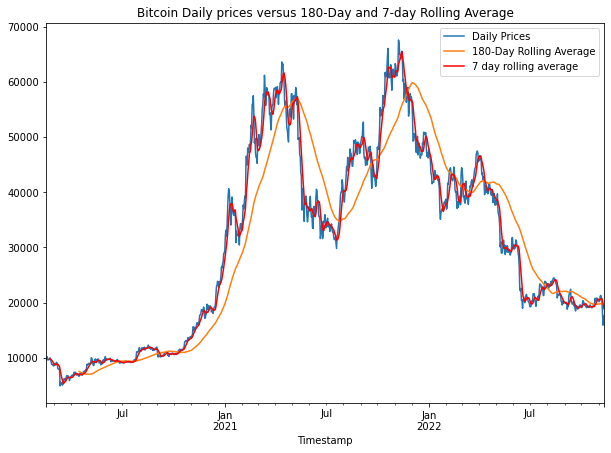

In [31]:
# btc_pct_change.rolling(window= 60).mean().plot()
# spy_pct_change.rolling(window= 60).mean().plot()
# ax = btc_annual_pct_change

ax = df_btc['Close'].plot(figsize=(10,7), title="Bitcoin Daily prices versus 180-Day and 7-day Rolling Average")
df_btc['Close'].rolling(window=60).mean().plot(ax=ax)
df_btc['Close'].rolling(window=7).mean().plot(ax=ax, color= 'red')
ax.legend(["Daily Prices", "180-Day Rolling Average", '7 day rolling average'])


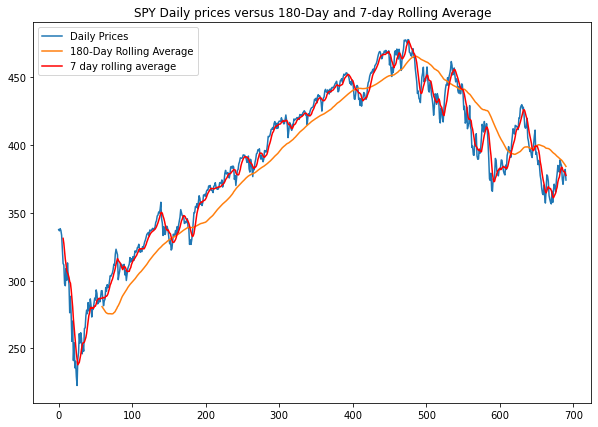

In [32]:
ax = df_spy['close'].plot(figsize=(10,7), title="SPY Daily prices versus 180-Day and 7-day Rolling Average")
df_spy['close'].rolling(window=60).mean().plot(ax=ax)
df_spy['close'].rolling(window=7).mean().plot(ax=ax, color= 'red')
ax.legend(["Daily Prices", "180-Day Rolling Average", '7 day rolling average'])

In [ ]:
MC_fiveyear = MCSimulation(
    portfolio_data = prices_df,
    weights = [.60,.40],
    num_simulation = 500,
    num_trading_days = 252*5
)


In [ ]:
# calculate the annual return for btc
btc_annual_pct_change = btc_pct_change.mean() * 365
btc_annual_pct_change

In [ ]:
# calculate the annual return for spy
spy_annual_pct_change = spy_pct_change.mean() * 252
spy_annual_pct_change

In [ ]:
# calculate the annual std for BTC
btc_annual_std = btc_pct_change.std() * (365) ** (1/2)
btc_annual_std

In [ ]:
# calculate the annual std for BTC
spy_annual_std = spy_pct_change.std()*  (365) ** (1/2)
spy_annual_std

In [ ]:
# calculate the sharpe ratio for BTC
btc_sharpe_ratio = btc_annual_pct_change / btc_annual_std
btc_sharpe_ratio

In [ ]:
# calculate the sharpe ratio for SPY
spy_sharpe_ratio = spy_annual_pct_change / spy_annual_std
spy_sharpe_ratio

In [ ]:
##### calculate the covariance from BTC to SPY
cov_btc_spy = btc_pct_change['Close'].cov(spy_pct_change['close'])
cov_btc_spy


In [ ]:
# plot the rolling std for spy and btc using a 60 day window
spy_rolling_std = spy_pct_change.rolling(window=60).std().plot()
btc_rolling_std = btc_pct_change.rolling(window=60).std().plot()

In [ ]:
frames = [spy_pct_change, btc_pct_change]
btc_spy_concat = pd.concat(frames)
btc_spy_concat

# plot the rolling std for spy using a 60 day window
spy_btc_rolling_std = btc_spy_concat.rolling(window=60).std().plot()

In [ ]:

def get_data_crypto():
    # Getting connected to binanceus exchange, can change to any other exchange listed above. 
    exchange_id = 'binanceus'
    exchange_class = getattr(ccxt, exchange_id)
    exchange = exchange_class({
    'timeout':30000,
    'enableRateLimit':True,
    })
    # exchange
    # load market data
    markets=exchange.load_markets()
    # getting open high low close data for BTC from binance us, last 1000 hour candles. 
    btc_ohlc = exchange.fetch_ohlcv('BTC/USD', timeframe='1d', limit=1000)
    # Creating a dataframe
    df_btc = pd.DataFrame(btc_ohlc,columns=['Timestamp','Open','High','Low','Close','Volume'])
    # Check for null values
    df_btc.isnull().sum().dropna()

    # taken unix to datetime from firas pandas extra demo code
    def unix_to_date(unix):
        return pd.to_datetime(unix, unit = "ms").tz_localize('UTC').tz_convert('US/Pacific')

    # Clean unix timestamp to a human readable timestamp. 
    df_btc['Timestamp']= df_btc['Timestamp'].apply(unix_to_date)
    # set index as timestamp
    df_btc = df_btc.set_index(['Timestamp'])
    return df_btc
    

get_data_crypto()



In [ ]:
# df_btc = df_btc.reset_index()
# df_btc['Timestamp'] = df_btc['Timestamp'].dt.strftime('%Y-%m-%d')
# df_btc.head()

df_btc.dtypes


In [ ]:
# Create the Alpaca API object
def get_data_qqq():
    alpaca = tradeapi.REST(
        ALPACA_API_KEY,
        ALPACA_SECRET_KEY,
        api_version="v2")

    # Format current date as ISO format 
    today = pd.Timestamp.now(tz="US/Pacific")
    a_year_ago = pd.Timestamp(today - pd.Timedelta(days=365)).isoformat()
    end_date = pd.Timestamp(today - pd.Timedelta(days=1)).isoformat()

    # Set the tickers
    tickers = ["QQQ"]


    # Set timeframe to one day ('1Day') for the Alpaca API
    timeframe = "1D"

    # Get current closing prices for NDX
    dqqq_price = alpaca.get_bars(
            tickers,
            timeframe,
            start=a_year_ago,
            end=end_date
        ).df

    # Display sample data
    # separate Ticker Data
    QQQ = dqqq_price[dqqq_price['symbol']=='QQQ'].drop('symbol', axis=1)
     
    # set the index as Timestamp
    # dqqq_price = dqqq_price.set_index(['Timestamp'])

    # Concatenate the Ticker DataFrames

    dqqq_price = pd.concat([QQQ],axis=1, keys=['QQQ'])
    return dqqq_price
    


In [ ]:
get_data_qqq()

In [ ]:

def get_data_spy():
    ALPACA_API_KEY = 'PK2BWJQC7W7Z3C87TKI6'
    ALPACA_SECRET_KEY = 'qox7s7aZ70L9yAp8HS6Kz0JXngu6a20ikuD3EmCq'
    
    # # Set the variables for the Alpaca API and secret keys
    # alpaca_api_key=os.getenv(ALPACA_API_KEY)
    # # Create the Alpaca tradeapi.REST object
    # alpaca_secret_key=os.getenv(ALPACA_SECRET_KEY)



    alpaca=tradeapi.REST(ALPACA_API_KEY,ALPACA_SECRET_KEY,api_version="v2")


    #Setting the tickers
    tickers = ['SPY']

    #Setting the timeframe
    timeframe='1Day'

    #Formatting the date
    today = pd.Timestamp.now(tz="US/Pacific")
    a_year_ago = pd.Timestamp(today - pd.Timedelta(days=1001)).isoformat()
    end_date = pd.Timestamp(today - pd.Timedelta(days=1)).isoformat()

    #Getting the closing prices
    spy_price = alpaca.get_bars(
    tickers,
    timeframe,
    start=a_year_ago,
    end=end_date
    ).df

    # Check for NaN Values
    spy_price.isnull().dropna()

    df_spy = spy_price.drop(columns=["trade_count","vwap","symbol"])
    return df_spy
    
get_data_spy()